# 平均に隠れた本音を暴く。混合モデルによる顧客満足度構造の深堀り
「満足度 3.5 点」という平均値の裏側には、「熱狂的なファン」と「静かな不満層」が混在している可能性がある。この「声なき多層構造」をベイズの千里眼で可視化し、商品・サービス改善の真の優先順位を特定する。

## ユースケース
新商品発売やリニューアル後、アンケート結果が「中途半端な平均値」に落ち着いてしまい、次の一手に迷っている。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Color Identity
COLOR_PURPLE = "#985DE5"
COLOR_BLUE   = "#118AB2"
COLOR_GREEN  = "#06D6A0"
COLOR_YELLOW = "#F9C74F"
COLOR_RED    = "#EF476F"
COLOR_GRAY   = "#8D99AE"

plt.rcdefaults()  # plt の現在のカラー定義をリセット
palette_brand = [COLOR_PURPLE, COLOR_BLUE, COLOR_GREEN, COLOR_YELLOW, COLOR_RED, COLOR_GRAY]

sns.set_theme(style="whitegrid", palette=palette_brand)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_brand)

In [3]:
# 可視化時に日本語を表示可能にする
import japanize_matplotlib

plt.rcParams["font.family"] = "IPAexGothic"

In [4]:
# n=30 の満足度データを生成（熱狂層: 0.6, 失望層: 0.4）
np.random.seed(42)

n_obs = 30
idx_group = np.random.choice([0, 1], size=n_obs, p=[0.6, 0.4])
mu_true = [4.5, 1.8]
sigma_true = [0.3, 0.5]

obs_satisfaction = np.random.normal(loc=np.array(mu_true)[idx_group], scale=np.array(sigma_true)[idx_group])
obs_satisfaction = np.clip(obs_satisfaction, 1.0, 5.0)

In [10]:
obs_satisfaction.mean()  # 観測データの平均を出力

np.float64(3.600766062133175)

## ビジネス課題の定義
### 課題
- 「平均 3.6 点」という数字では、改善すべき点が「全員にとってのあと一歩」なのか、「一部の深刻な不満」なのか判別できない。
- 全員の平均を取ることで、熱狂的なファンの尖った評価が埋もれ、凡庸な施策に陥るリスクがある。

### 解決したい「問い」
- 満足度データの中に、異なる評価軸を持つ「隠れたグループ」はいくつ存在するか？
- 各グループの構成比率と、それぞれの平均的な満足度はどの程度か？

## EDA (Exploratory Data Analysis)
記述統計量に頼らず、ヒストグラムでデータのモダリティ（山の数）を把握する。

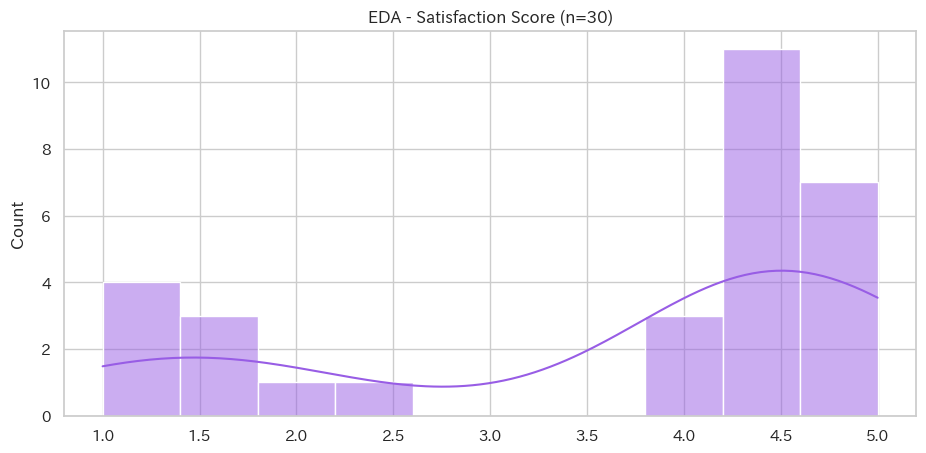

In [13]:
# ヒストグラムで分布を確認
plt.figure(figsize=(11, 5))
sns.histplot(obs_satisfaction, bins=10, kde=True)
plt.title(f"EDA - Satisfaction Score (n={n_obs})")
plt.show()

単一の正規分布では説明しきれない「二峰性」があることを確認。

## 戦略的問い立て（OS の選択）
観測データ: $D$ が単一の確率分布から生成されたと見なさず、複数の潜在的なサブグループ（コンポーネント） $k$ の重ね合わせとしてモデル化する。
>数式: 全体の分布 $f(x)$ を各グループの比率 $w_k$ と分布 $f_k$ の積の総和として表現
>
>$f(x) = \sum_{k=1}^{k} w_k f_k(x|\theta_k)$

### OS (エンジン)
階層ベイズの考え方を応用した混合モデル

#### 選定根拠
1. 個性と共通性の共存 (階層性の応用)
    階層ベイズは「個別のデータの違い」を認めつつ、「全体としての共通性」も加味する手法です。混合モデルはこの考え方を応用し、「顧客一人ひとりは違うが、大きく分ければ数種類のタイプ（セグメント）に集約される」という仮説を構造化する。
    これにより、「個別のバラツキ」に惑わされず、「集団としての傾向」を安定して抽出可能に。
2. 小規模データにおける「確信」の担保
    今回の $n=30$ というデータ量は、一般的な統計手法では「有意差なし」や「過学習」のリスクが高い領域。
    - **事前知識の活用**: 「顧客には満足層と不満層がいるはずだ」という業界知見を事前分布として組み込むことで、少ないデータからでも効率的に構造を表現。
    - **不確実性の可視化** : 抽出されたセグメント比率 $w$ や平均値 $\mu$ を「点」ではなく「分布(幅)」として算出するため、経営者は「最悪のシナリオ」を想定した意思決定が可能に。
3. 意思決定プロセス「期待効用」への直結
    混合モデルを選ぶ最大のビジネス的メリットは、「どのグループをターゲットにすべきか」が確率的に計算可能になる点。
    - 単一の平均値モデルでは「全員に対して一律の施策」しか提案できません。
    - 混合モデル (OS)であれば、「40%の失望層を救う施策」と「60%の熱狂層を維持する施策」のそれぞれの投資対効果（期待効用） を天秤にかけることができる。